从两个角度判断时序数据是否平稳
1、从图形看，活动固定于具有上下界的区域
2、通过Dickey-Fuller test 来检测序列是否存在单位根
[CSDN Dickey-Fuller test](https://blog.csdn.net/WHYbeHERE/article/details/115531176?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522168230264816800197066585%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=168230264816800197066585&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-4-115531176-null-null.142^v86^koosearch_v1,239^v2^insert_chatgpt&utm_term=Dickey-Fuller%20test&spm=1018.2226.3001.4187)

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
font = FontProperties(fname="SimHei.ttf", size=14)

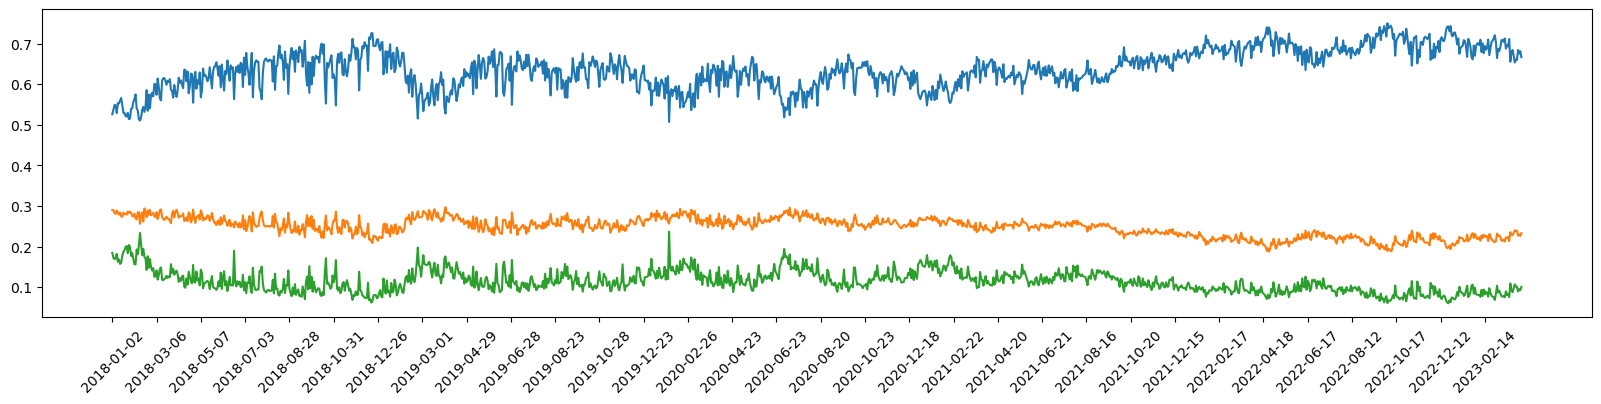

In [22]:
df = pd.read_csv('主动买入成交占比.csv')
plt.figure(figsize=(20, 4))
plt.plot(df.set_index('交易日期', drop=True).iloc[:, :3])
plt.xticks(list(df.index[::40]), rotation=45)
plt.show()

当一个自回归过程中：$y_t = by_{t − 1} + a + \epsilon t$，如果滞后项系数b为1，就称为单位根。当单位根存在时，自变量和因变量之间的关系具有欺骗性，因为残差序列的任何误差都不会随着样本量（即时期数）增大而衰减，也就是说模型中的残差的影响是永久的。这种回归又称作伪回归。如果单位根存在，这个过程就是一个随机漫步（random walk）。
ADF检验就是判断序列是否存在单位根：如果序列平稳，就不存在单位根；否则，就会存在单位根。

H0原假设：序列有单位根（值a=1）
备择假设：序列没有单位根
如果我们不能拒绝零，我们可以说序列是非平稳的，这意味着序列可以是线性或差分平稳的

如果得到的显著性检验统计量小于三个置信度（10%，5%，1%），则对应有（90%，95，99%）的把握来拒绝原假设。

### 去除交易活动中的趋势

In [23]:
index_df = pd.read_csv('SSE.csv')
index_df = index_df.sort_values(by='trade_date', ascending=True).loc[:, ['trade_date', 'close']].rename(columns={'trade_date': '交易日期', 'close': 'SSE close'})
index_df['交易日期'] = pd.to_datetime(index_df['交易日期'], format='%Y%m%d')
df['交易日期'] = pd.to_datetime(df['交易日期'])
df = df.merge(index_df, on='交易日期')

[MACD - diff的计算](https://blog.csdn.net/enb330/article/details/126596072?ops_request_misc=&request_id=&biz_id=&utm_medium=distribute.pc_search_result.none-task-blog-2~all~koosearch~default-2-126596072-null-null.142^v86^koosearch_v1,239^v2^insert_chatgpt&utm_term=MACD%20dif%20python&spm=1018.2226.3001.4187)

In [24]:
# 对原有的不同类型投资者的成交数据进行去噪
# n 日移动平均买入额 =（短期买入额*（n-1)+当日买入额*2）/（n+1)
# n 日移动平均成交额 =（短期成交额*（n-1)+当日成交额*2）/（n+1)

df['ema_12_sm'] = df['小单买入额(万元)'].ewm(alpha=2 / 13, adjust=False).mean()
df['ema_26_sm'] = df['小单买入额(万元)'].ewm(alpha=2 / 27, adjust=False).mean()
df['ema_12_md'] = df['中单买入额(万元)'].ewm(alpha=2 / 13, adjust=False).mean()
df['ema_26_md'] = df['中单买入额(万元)'].ewm(alpha=2 / 27, adjust=False).mean()
df['ema_12_lg'] = df['大单买入额(万元)'].ewm(alpha=2 / 13, adjust=False).mean()
df['ema_26_lg'] = df['大单买入额(万元)'].ewm(alpha=2 / 27, adjust=False).mean()

df['ema_12_SSE'] = df['SSE close'].ewm(alpha=2 / 13, adjust=False).mean()
df['ema_26_SSE'] = df['SSE close'].ewm(alpha=2 / 27, adjust=False).mean()

In [25]:
# 投资者活跃度 = （S 日移动平均买入额 / S 日移动平均成交额） - （L日移动平均买入额 / L 日移动平均成交额）
df['知情交易者交易活跃度'] = (df['ema_12_lg'] / df['ema_12_SSE']) - (df['ema_26_lg'] / df['ema_12_SSE'])
df['趋势追踪者交易活跃度'] = (df['ema_12_md'] / df['ema_12_SSE']) - (df['ema_26_md'] / df['ema_12_SSE'])
df['跟随交易者交易活跃度'] = (df['ema_12_sm'] / df['ema_12_SSE']) - (df['ema_26_sm'] / df['ema_12_SSE'])

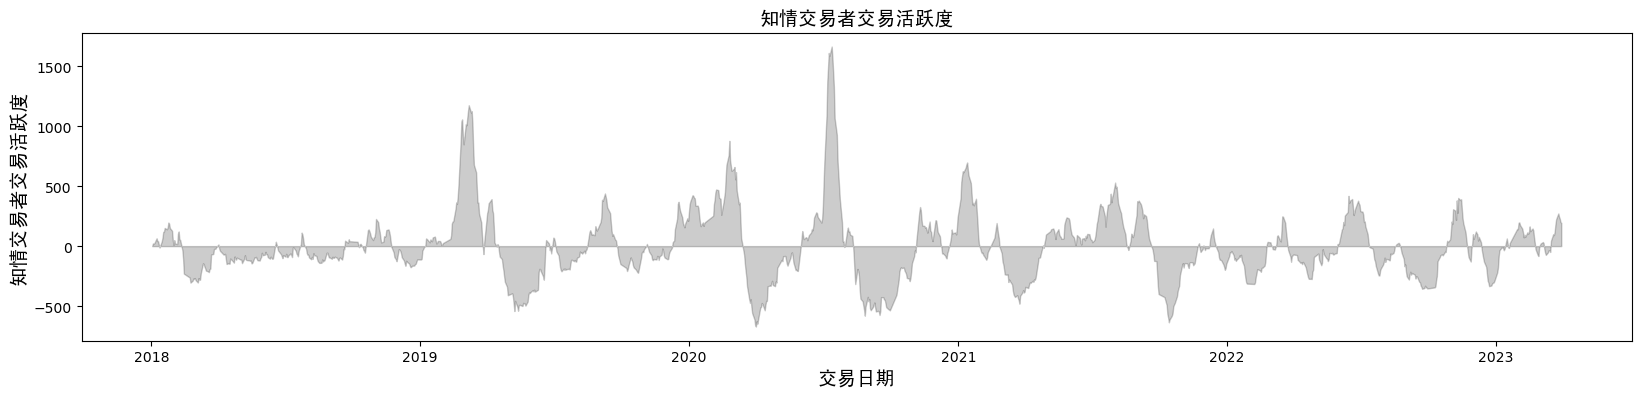

In [32]:
plt.figure(figsize=(20, 4))

x = df['交易日期']
y = df['知情交易者交易活跃度']
plt.fill_between(x, y, color='black', alpha=0.2)  # 绘制面积图

plt.title('知情交易者交易活跃度', fontproperties=font)
plt.xlabel('交易日期', fontproperties=font)
plt.ylabel('知情交易者交易活跃度', fontproperties=font)
plt.show()

# 以知情交易者的投资活跃度为例，从图中可以看出，投资者活跃度指标在窄幅区间中运动，并且符合均值回复的特征。

In [36]:
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['知情交易者交易活跃度'])
print('知情交易者交易活跃度')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

result = adfuller(df['大单买入额(万元)'])
print('知情交易者买入额')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# 均通过了平稳性检验

知情交易者交易活跃度
ADF Statistic: -6.085257
p-value: 0.000000
知情交易者买入额
ADF Statistic: -3.661710
p-value: 0.004685


In [38]:
df.to_csv('交易活跃度.csv', index=False)